<a href="https://colab.research.google.com/github/eueu29/AIFFEL_quest/blob/main/Exploration_quest/Quest04/quest04_dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# dcgan model test trial

In [ ]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


## 데이터셋 구성하기

In [ ]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170508288/170498071 [==============================] - 3s 0us/step


(50000, 32, 32, 3)

In [ ]:
# -1~1사이의 값으로 정규화
train_x = (train_x - 127.5) /127.5

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [ ]:
train_x.shape
# 컬러 채널 차원이 잇어서 reshape은 skip함

(50000, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


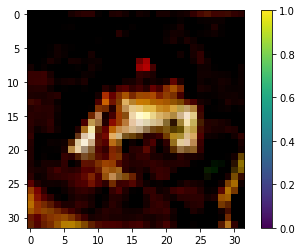

In [ ]:
# # 이미지 출력하여 확인
# # plt.imshow(train_x[0].reshape(32,32), cmap='')
# plt.imshow(train_x[0])
# plt.colorbar()
# plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

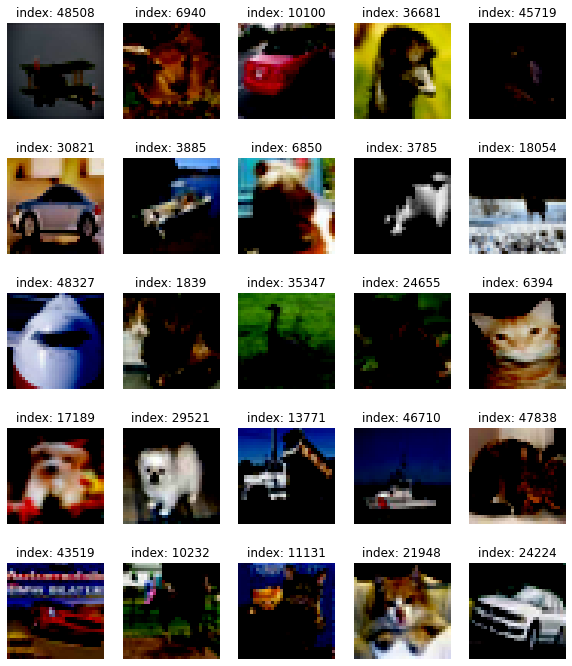

In [ ]:
# # 랜덤으로 10개 출력하기
# plt.figure(figsize=(10, 12))

# for i in range(25):
#     plt.subplot(5, 5, i+1)
#     random_index = np.random.randint(1, 50000)
#     plt.imshow(train_x[random_index])
#     plt.title(f'index: {random_index}')
#     plt.axis('off')

# plt.show()

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 모델 구현하기

## 생성자 모델

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

def make_generator_model():
    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    # units은 8x8x256, 편향은 사용하지 않음, 입력 값의 크기는 100차원 벡터
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    # 배치 정규화 사용
    model.add(layers.BatchNormalization())
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)  # 주목: 배치사이즈로 None이 주어집니다.

    # Third: Conv2DTranspose layer
    # 커널 크기는 5, stride는 2, 패딩은 사용, 편향은 사용하지 않음
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    # 커널 크기는 5, stride는 2, 패딩은 사용, 편향은 사용하지 않음
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    # 커널 크기는 5, stride는 1, 패딩은 사용, 출력 채널 수는 3, 활성화 함수는 'tanh'
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 3)

    return model

In [ ]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0

## 판별자 모델

In [ ]:
def make_discriminator_model():
    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    # 필터의 크기는 5이며 64개 사용, stride는 2, 패딩은 사용, 입력 값의 크기는 준비된 RGB 사진
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(32, 32, 3)))
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())
    # Dropout은 0.3을 사용
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    # 필터의 크기는 5이며 128개 사용, stride는 2, 패딩은 사용
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())
    # Dropout은 0.3을 사용
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

## 손실함수와 최적화 함수

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    #진짜 이미지에 대해 판별기가 '진짜'라고 평가한 출력과 '진짜' 레이블(모든 값이 1인 텐서)의 손실값
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    #생성된 이미지에 대해 판별기가 '가짜'라고 평가한 출력과 '가짜' 레이블(모든 값이 0인 텐서)의 손실값
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    # real_loss와 fake_loss를 더한 값
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [ ]:
# 성자와 구분자는 따로따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 따로 만들어주어야 한다
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
#샘플은 한 번에 16장을 생성
#고정된 seed로 100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터를 만들기
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [ ]:
# `tf.function`이 어떻게 사용되는지 주목해 주세요.
# 이 데코레이터는 함수를 "컴파일"합니다.

@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)

    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [ ]:
# 한 단계씩 학습할 train_step과 함께 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [ ]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')

    # summarize history for accuracy
    plt.subplot(212)
    plt.plot(history['fake_accuracy'])
    plt.plot(history['real_accuracy'])
    plt.title('discriminator accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('batch iters')
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')

    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [ ]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_history'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [ ]:
# 그러면 모델을 저장하는 간격을 담당하는 save_every와 전체 학습 에포크를 결정하는 EPOCHS 파라미터도 설정
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

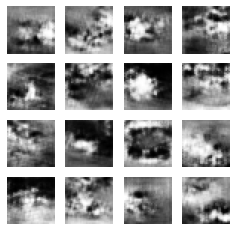

Time for training : 1263 sec


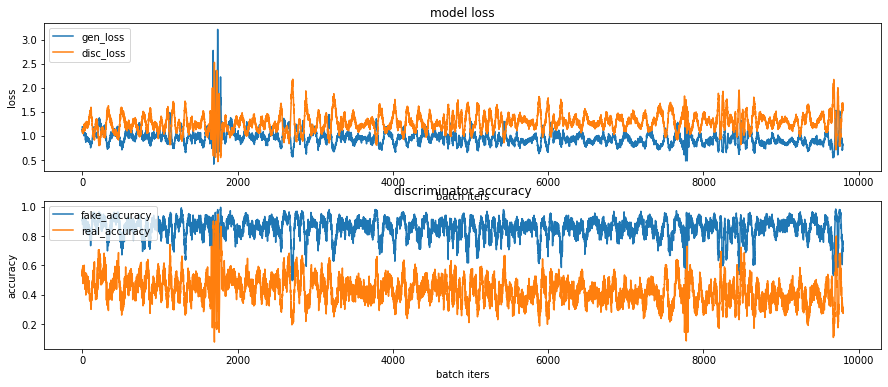

CPU times: user 21min 6s, sys: 1min 21s, total: 22min 28s
Wall time: 21min 4s


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every=save_every)
# 학습과정의 loss, accuracy 그래프 이미지 파일이 지정 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

이미지가 많이 뭉개져있고 선명하지 못한 모습...

In [ ]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 1285723 Aug 21 06:02 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


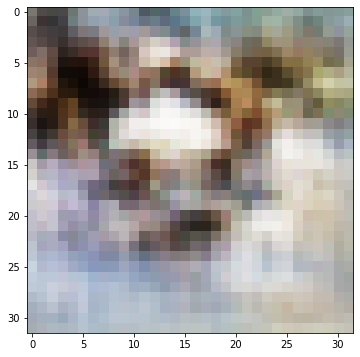

In [ ]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다.
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

나름 학습한 checkpoint 내에서 무언가를 생성해냈으나 형상을 알아볼 정도로 생성되지는 못함  
epoch별로 어떻게 진보했는지 출력해보면...

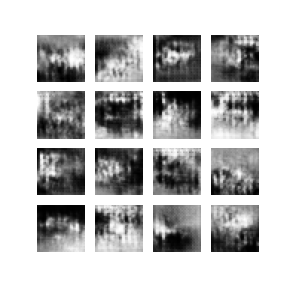

In [ ]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_0001_iter_151.png'
PIL.Image.open(checkpoint_dir)

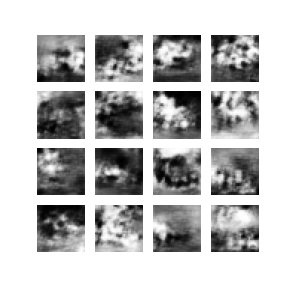

In [ ]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_0027_iter_151.png'
PIL.Image.open(checkpoint_dir)

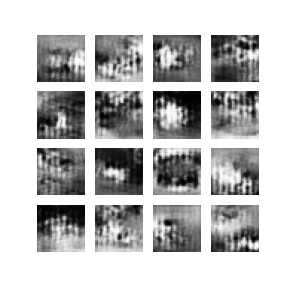

In [ ]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_0050_iter_151.png'
PIL.Image.open(checkpoint_dir)

추가로 뭐가 나아졌는지는 잘 모르겠다

**50 epoch 추가로 돌려보기**

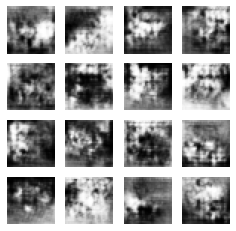

Time for training : 1257 sec


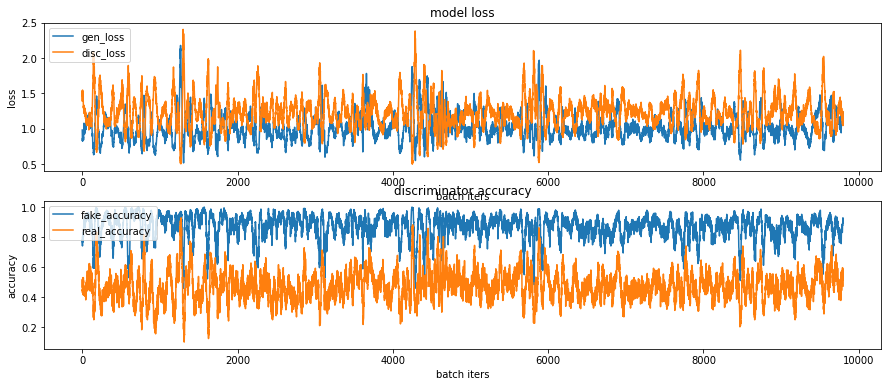

CPU times: user 20min 57s, sys: 1min 21s, total: 22min 18s
Wall time: 20min 58s


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

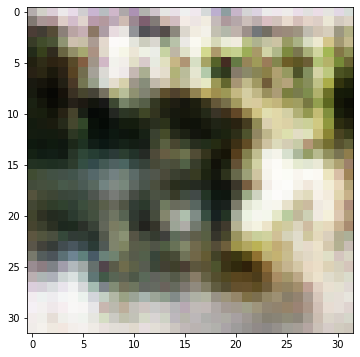

In [ ]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다.
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

# dcgan에서 학습 결과 + 원본 이미지가 같이 출력되게끔 수정해봄

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np

# 데이터셋 로드
(train_images, _), (_, _) = tf.keras.datasets.cifar10.load_data()
train_images = (train_images-127.5) / 127.5  # Normalize to [-1, 1]


In [ ]:
train_images.shape

(50000, 32, 32, 3)

In [ ]:
# 하이퍼파라미터
BUFFER_SIZE = 60000
BATCH_SIZE = 256
IMG_HEIGHT = 32
IMG_WIDTH = 32
CHANNELS = 3
LATENT_DIM = 100
EPOCHS = 50

# 데이터셋 준비
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
# 생성기 모델 정의
def build_generator():
    model = Sequential([
        Dense(8 * 8 * 256, use_bias=False, input_shape=(LATENT_DIM,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),

        Reshape((8, 8, 256)),

        Conv2DTranspose(128, kernel_size=5, strides=2, padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),

        Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),

        Conv2DTranspose(3, kernel_size=5, strides=1, padding='same', use_bias=False, activation='tanh')
    ])
    return model

# 판별기 모델 정의
def build_discriminator():
    model = Sequential([
        Conv2D(64, kernel_size=5, strides=2, padding='same', input_shape=[IMG_HEIGHT, IMG_WIDTH, CHANNELS]),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),

        Conv2D(128, kernel_size=5, strides=2, padding='same'),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),

        Flatten(),
        Dense(1)
    ])
    return model

# 손실 함수 및 최적화기 정의
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator = build_generator()
discriminator = build_discriminator()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
generator.summary()
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_5 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 16, 16, 128)       819200    
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16, 16, 128)      

In [ ]:
# 학습 루프 정의
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))



Epoch 1/50 완료
Epoch 2/50 완료
Epoch 3/50 완료
Epoch 4/50 완료
Epoch 5/50 완료
Epoch 6/50 완료
Epoch 7/50 완료
Epoch 8/50 완료
Epoch 9/50 완료
Epoch 10/50 완료
Epoch 11/50 완료
Epoch 12/50 완료
Epoch 13/50 완료
Epoch 14/50 완료
Epoch 15/50 완료
Epoch 16/50 완료
Epoch 17/50 완료
Epoch 18/50 완료
Epoch 19/50 완료
Epoch 20/50 완료
Epoch 21/50 완료
Epoch 22/50 완료
Epoch 23/50 완료
Epoch 24/50 완료
Epoch 25/50 완료
Epoch 26/50 완료
Epoch 27/50 완료
Epoch 28/50 완료
Epoch 29/50 완료
Epoch 30/50 완료
Epoch 31/50 완료
Epoch 32/50 완료
Epoch 33/50 완료
Epoch 34/50 완료
Epoch 35/50 완료
Epoch 36/50 완료
Epoch 37/50 완료
Epoch 38/50 완료
Epoch 39/50 완료
Epoch 40/50 완료
Epoch 41/50 완료
Epoch 42/50 완료
Epoch 43/50 완료
Epoch 44/50 완료
Epoch 45/50 완료
Epoch 46/50 완료
Epoch 47/50 완료
Epoch 48/50 완료
Epoch 49/50 완료
Epoch 50/50 완료


In [ ]:
# 모델 학습
for epoch in range(EPOCHS):
    for image_batch in train_dataset:
        train_step(image_batch)

    print(f'Epoch {epoch + 1}/{EPOCHS} 완료')

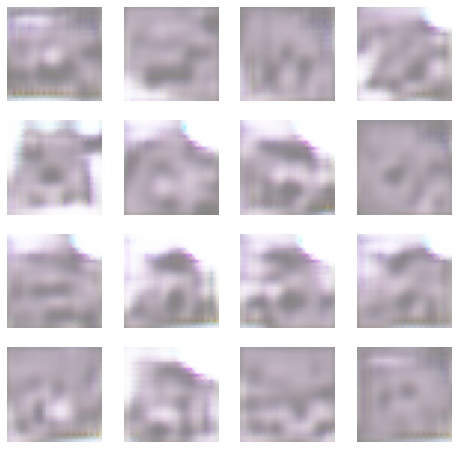

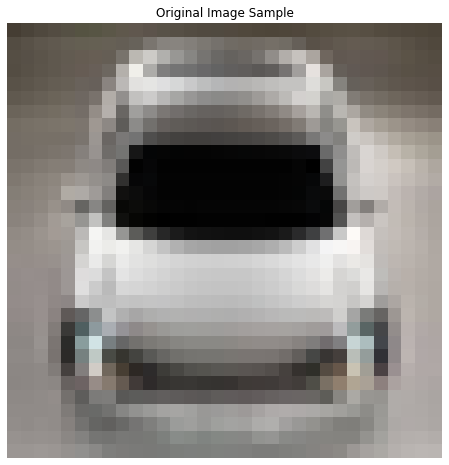

In [ ]:
# 이미지 생성 및 시각화
def plot_images(generator, epoch, examples=16, dim=(4, 4), figsize=(8, 8)):
    noise = tf.random.normal([examples, LATENT_DIM])
    generated_images = generator(noise, training=False)
    generated_images = (generated_images + 1) / 2.0  # Rescale images to [0, 1]

    fig, axs = plt.subplots(dim[0], dim[1], figsize=figsize)
    cnt = 0
    for i in range(dim[0]):
        for j in range(dim[1]):
            axs[i,j].imshow(generated_images[cnt])
            axs[i,j].axis('off')
            cnt += 1
    plt.show()

    # 원본 이미지의 일부분도 출력
    plt.figure(figsize=(8, 8))
    plt.imshow(train_images[np.random.randint(0, train_images.shape[0])])
    plt.title('Original Image Sample')
    plt.axis('off')
    plt.show()

plot_images(generator, EPOCHS)

# hugging face model pipeline으로 가져와 사용해보기(pix2pix model)

[Hugging face의 pix2pix model](https://huggingface.co/timbrooks/instruct-pix2pix)

In [ ]:
pip install diffusers accelerate safetensors transformers

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

## model import

In [ ]:
import PIL
import requests
import torch
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler

model_id = "timbrooks/instruct-pix2pix"
pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(model_id, torch_dtype=torch.float16, safety_checker=None)
pipe.to("cuda")
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

## 1st image

In [ ]:
import matplotlib.pyplot as plt

def download_image(url):
    image = PIL.Image.open(requests.get(url, stream=True).raw)
    image = PIL.ImageOps.exif_transpose(image)
    image = image.convert("RGB")
    return image

# 이미지 다운로드
url = "https://raw.githubusercontent.com/timothybrooks/instruct-pix2pix/main/imgs/example.jpg"
original_image = download_image(url)

# 변환 작업 수행
prompt = "turn him into cyborg"
generated_images = pipe(prompt, image=original_image, num_inference_steps=10, image_guidance_scale=1).images
generated_image = generated_images[0]

  0%|          | 0/10 [00:00<?, ?it/s]

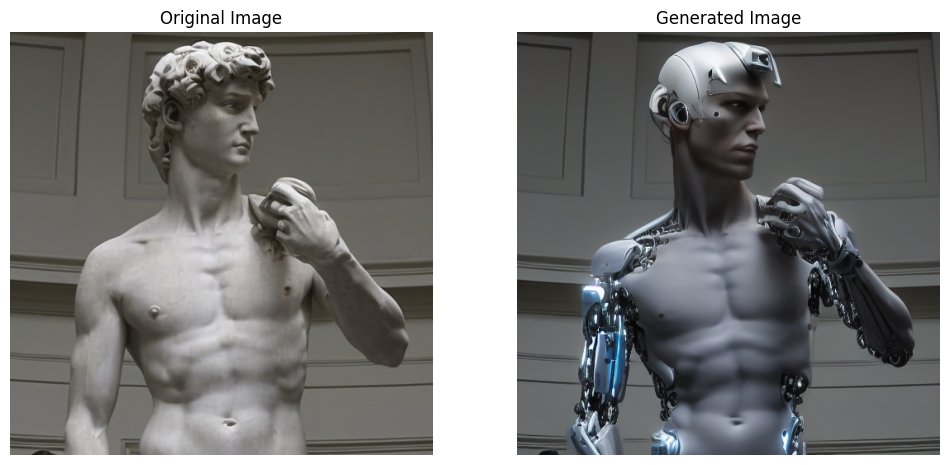

In [ ]:
# 원본 이미지와 생성된 이미지 출력
def display_images(original, generated):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(original)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(generated)
    axes[1].set_title('Generated Image')
    axes[1].axis('off')

    plt.show()

# 이미지 출력
display_images(original_image, generated_image)

## 2nd image

  0%|          | 0/10 [00:00<?, ?it/s]

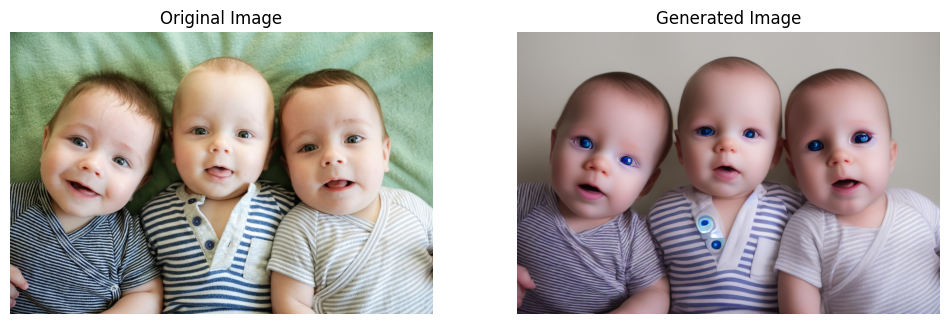

In [ ]:
# 이미지 다운로드
url = "https://www.ohbaby.co.nz/media/4115456/personality-traits.jpg"
original_image = download_image(url)

# 변환 작업 수행
prompt = "turn the babies into cyborg"
generated_images = pipe(prompt, image=original_image, num_inference_steps=10, image_guidance_scale=1).images
generated_image = generated_images[0]

# 이미지 출력
display_images(original_image, generated_image)

  0%|          | 0/10 [00:00<?, ?it/s]

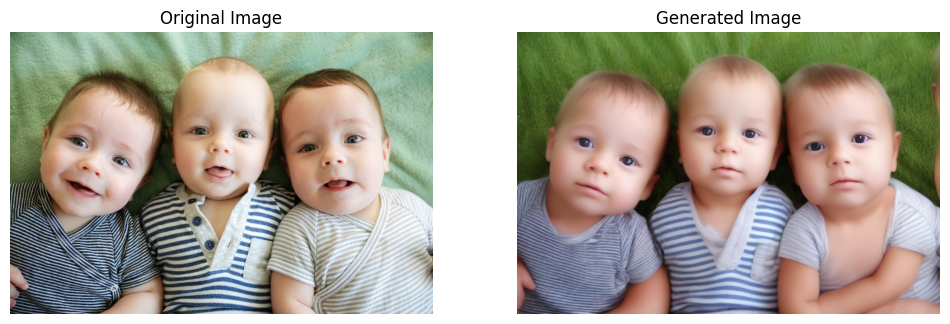

In [ ]:
# 변환 작업 수행
prompt = "what will they look like when they get older?"
generated_images = pipe(prompt, image=original_image, num_inference_steps=10, image_guidance_scale=1).images
generated_image = generated_images[0]

# 이미지 출력
display_images(original_image, generated_image)

  0%|          | 0/10 [00:00<?, ?it/s]

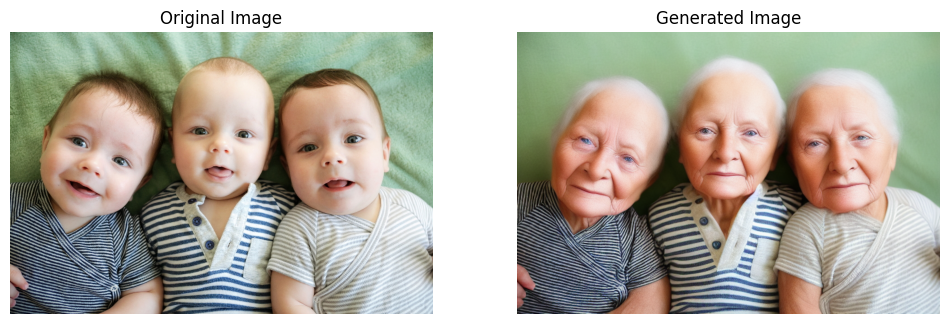

In [ ]:
# 변환 작업 수행
prompt = "what will they look like in age 70?"
generated_images = pipe(prompt, image=original_image, num_inference_steps=10, image_guidance_scale=1).images
generated_image = generated_images[0]

# 이미지 출력
display_images(original_image, generated_image)

  0%|          | 0/10 [00:00<?, ?it/s]

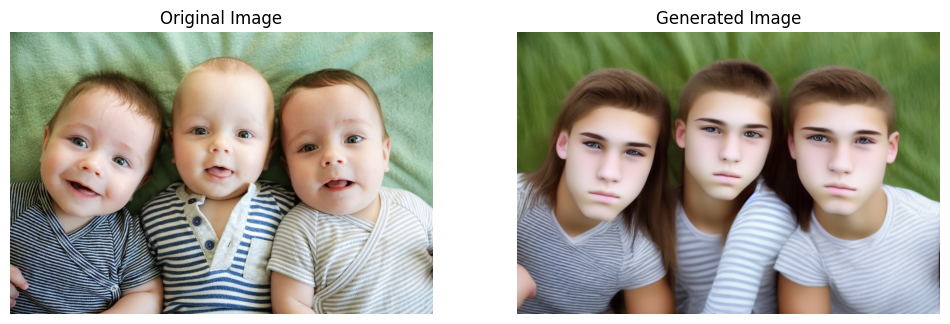

In [ ]:
# 변환 작업 수행
prompt = "what will they look like in teens?"
generated_images = pipe(prompt, image=original_image, num_inference_steps=10, image_guidance_scale=1).images
generated_image = generated_images[0]

# 이미지 출력
display_images(original_image, generated_image)

  0%|          | 0/10 [00:00<?, ?it/s]

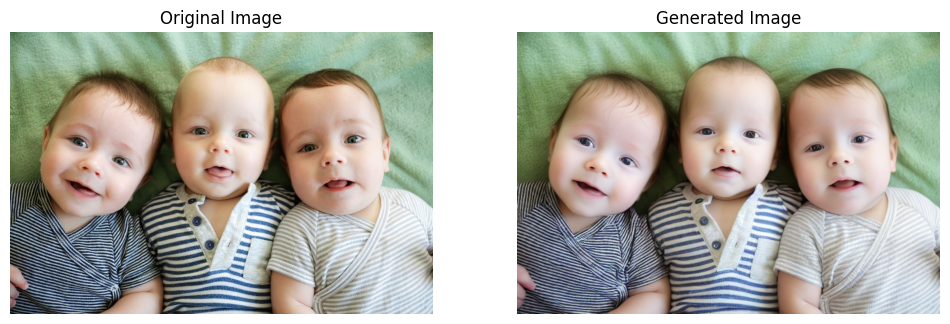

In [ ]:
# 변환 작업 수행
prompt = "the baby in the center is a girl, and rest of them are boys, what will they look like in age 70?"
generated_images = pipe(prompt, image=original_image, num_inference_steps=10, image_guidance_scale=1).images
generated_image = generated_images[0]

# 이미지 출력
display_images(original_image, generated_image)

## 3rd image

  0%|          | 0/10 [00:00<?, ?it/s]

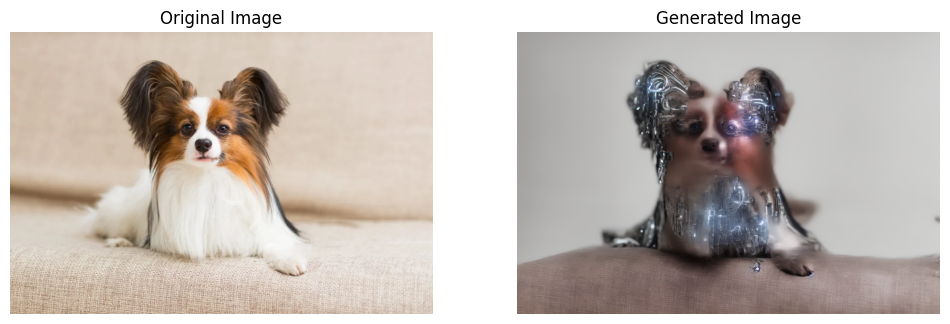

In [ ]:
# 이미지 다운로드
url = "https://dogtime.com/wp-content/uploads/sites/12/2011/01/GettyImages-919583490-e1692807780270.jpg"
original_image = download_image(url)

# 변환 작업 수행
prompt = "turn him into cyborg"
generated_images = pipe(prompt, image=original_image, num_inference_steps=10, image_guidance_scale=1).images
generated_image = generated_images[0]

# 이미지 출력
display_images(original_image, generated_image)

  0%|          | 0/10 [00:00<?, ?it/s]

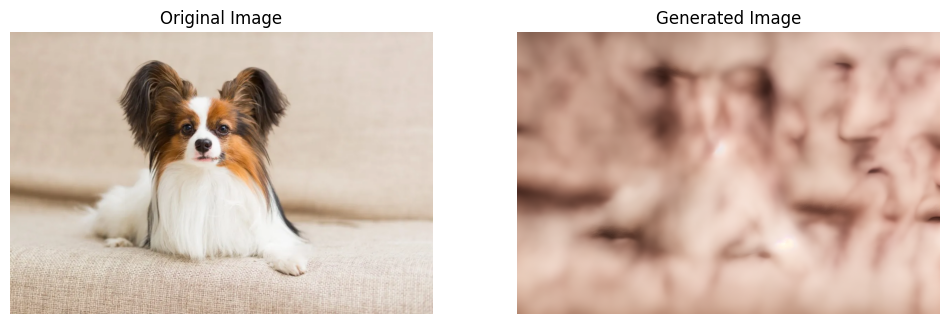

In [ ]:
# 변환 작업 수행
prompt = "turn him into human"
generated_images = pipe(prompt, image=original_image, num_inference_steps=10, image_guidance_scale=1).images
generated_image = generated_images[0]

# 이미지 출력
display_images(original_image, generated_image)

  0%|          | 0/10 [00:00<?, ?it/s]

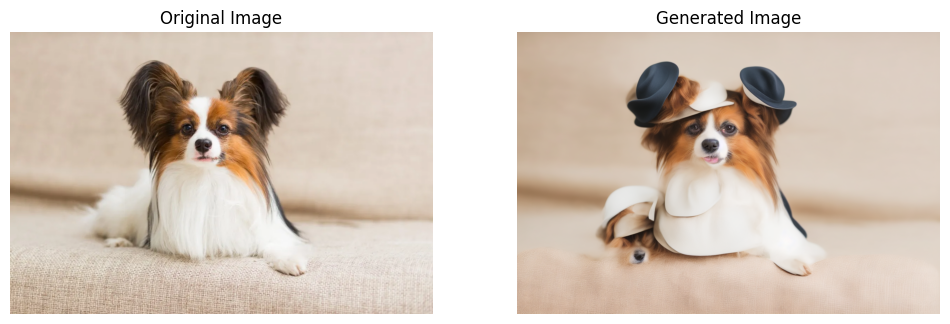

In [ ]:
# 변환 작업 수행
prompt = "put on a hat on the dog's head"
generated_images = pipe(prompt, image=original_image, num_inference_steps=10, image_guidance_scale=1).images
generated_image = generated_images[0]

# 이미지 출력
display_images(original_image, generated_image)